In [ ]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import UpSampling2D, Conv2D, Activation, Input, concatenate, BatchNormalization
import albumentations as A
import cv2

from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Google colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read DataSet
train_image = "/content/drive/MyDrive/Data/train"
test_image = "/content/drive/MyDrive/Data/test"

# get all image names in train file
pnevmonia = os.listdir(train_image + "/PNEUMONIA")
normal = os.listdir(train_image + "/NORMAL")
COVID_19 = os.listdir(test_image + "/COVID19")

## Image generator, prepare data

In [ ]:
def get_trans(image):
    transform = A.Compose([
        A.ChannelShuffle(always_apply=False, p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=5, p=0.2),
        A.CenterCrop(p=0.2, height=512, width=512)
    ])
    z = transform(image=image)['image']
    return z

In [ ]:
bartch_size = 7

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=get_trans, validation_split=0.09)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_datagen.flow_from_directory(train_image,
                                              target_size=(512, 512),
                                              batch_size=bartch_size,
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

train_gen_val = train_datagen.flow_from_directory(train_image,
                                                  target_size=(512, 512),
                                                  batch_size=bartch_size,
                                                  class_mode='categorical',
                                                  subset='validation',
                                                  shuffle=True)

test_gen = test_datagen.flow_from_directory(test_image,
                                            target_size=(512, 512),
                                            batch_size=bartch_size,
                                            class_mode='categorical',
                                            shuffle=False)

Found 4683 images belonging to 3 classes.
Found 461 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
def getSamplesFromDataGen(resultData):
    x = resultData.next()  # fetch the first batch
    a = x[0]  # train data
    b = x[1]  # train label
    for i in range(0, 3):
        print(a[i].shape)
        plt.imshow(a[i])
        plt.show()

In [ ]:
def history_visualize(history, name = 'Resnet50'):
  fig, axes = plt.subplots(2, 1, figsize=(14, 14))
  axes[0].set_title('{} acc'.format(name), fontsize=14)
  axes[0].set_ylabel('val_aac', fontsize=14)
  axes[0].plot(history.history['accuracy'])
  axes[0].plot(history.history['val_accuracy'])
  axes[0].legend(['Train data', 'Validation data'], loc='upper left')


  axes[1].set_title('{} aac'.format(name), fontsize=14)
  axes[1].set_ylabel('Loss', fontsize=14)
  axes[1].plot(history.history['loss'])
  axes[1].plot(history.history['val_loss'])
  axes[1].legend(['Train data', 'Validation data'], loc='upper left', fontsize=14)
  
  plt.show()

##  Custom Unet

In [ ]:
def downsampling(data, num_filters, kernel=(3, 3), padding='same', kernel_initializer='he_normal'):
    conv1 = Conv2D(num_filters, kernel, kernel_initializer=kernel_initializer,
                   padding=padding, activation="relu")(data)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(num_filters, kernel, kernel_initializer=kernel_initializer,
                   padding=padding, activation="relu")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    return pool1, conv1


def upsampling(data, down_data, num_filters, kernel=(3, 3), padding='same', kernel_initializer='he_normal'):
    up_s = (UpSampling2D(size=(2, 2))(data))
    merge = concatenate([down_data, up_s], axis=3)
    conv2 = Conv2D(num_filters, 3, activation='relu', padding=padding, kernel_initializer=kernel_initializer)(merge)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(num_filters, 3, activation='relu', padding=padding, kernel_initializer=kernel_initializer)(conv2)
    conv2 = BatchNormalization()(conv2)
    return conv2


def bottleneck(data, filters, padding="same", kernel_initializer='he_normal'):
    bottle_conv = keras.layers.Conv2D(filters, (3, 3), padding=padding, kernel_initializer='he_normal')(data)
    bottle_norm = BatchNormalization()(bottle_conv)
    d1 = Conv2D(filters, (1, 1), dilation_rate=2)(bottle_norm)
    d2 = Conv2D(filters, (1, 1), dilation_rate=4)(d1)
    d3 = Conv2D(filters, (1, 1), dilation_rate=8)(d2)
    conv = keras.layers.Concatenate()([d1, d2, d3])
    return conv

In [ ]:
def custom_Unet(height=512, width=512):
    Step = [8, 16, 32, 64, 128, 256, 512]
    input = keras.layers.Input((height, width, 3))

    pool1, conv1 = downsampling(input, Step[0])  # 512 -> 256
    pool2, conv2 = downsampling(pool1, Step[1])  # 256 -> 128
    pool3, conv3 = downsampling(pool2, Step[2])  # 128 -> 64
    pool4, conv4 = downsampling(pool3, Step[3])  # 64 -> 32
    pool5, conv5 = downsampling(pool4, Step[4])  # 32 -> 16
    pool6, conv6 = downsampling(pool5, Step[5])  # 16 -> 8

    bottle_neck = bottleneck(pool6, Step[6])

    up1 = upsampling(bottle_neck, conv6, Step[5])  # 8 -> 16
    up2 = upsampling(up1, conv5, Step[4])  # 16 -> 32
    up3 = upsampling(up2, conv4, Step[3])  # 32 -> 64
    # up4 = upsampling(up3, conv3, Step[2])  # 64 -> 128
    # up5 = upsampling(up4, conv2, Step[1])  # 128 -> 256
    # up6 = upsampling(up5, conv1, Step[0])  # 256 -> 512
    layer_0 = keras.layers.Flatten()(pool6)
    layer_1 = keras.layers.Dense(256, activation='relu')(layer_0)
    layer_1_norm = BatchNormalization()(layer_1)
    layer_2 = keras.layers.Dense(128, activation='relu')(layer_1_norm)
    output = keras.layers.Dense(units=3, activation="softmax")(layer_2)
    return keras.models.Model(input, output)

In [ ]:
model_unet = custom_Unet()
model_unet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 512, 8)       32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 16)      64    

In [ ]:
checkpoint_path = r"/content/drive/MyDrive/Data/Unet1_custom_visual.hdf5"

callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True,
                                    save_weights_only=False, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=1, mode='auto')
]

optim = keras.optimizers.Adam(lr=0.0001)
metrics = ['accuracy']

model_unet.compile(optimizer=optim, loss=keras.losses.categorical_crossentropy, metrics=metrics)

In [ ]:
history_unet = model_unet.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=15,
    callbacks=callbacks,
    validation_data=train_gen_val,
    validation_steps=len(train_gen_val),
    class_weight=None)

Epoch 1/40
669/669 [==============================] - 385s 575ms/step - loss: 0.1205 - accuracy: 0.9569 - val_loss: 0.2169 - val_accuracy: 0.9219

Epoch 00001: val_accuracy did not improve from 0.92625
Epoch 2/40
669/669 [==============================] - 375s 560ms/step - loss: 0.1385 - accuracy: 0.9494 - val_loss: 0.2240 - val_accuracy: 0.9002

Epoch 00002: val_accuracy did not improve from 0.92625
Epoch 3/40
669/669 [==============================] - 386s 578ms/step - loss: 0.1300 - accuracy: 0.9541 - val_loss: 0.2512 - val_accuracy: 0.9111

Epoch 00003: val_accuracy did not improve from 0.92625
Epoch 4/40
669/669 [==============================] - 373s 558ms/step - loss: 0.1108 - accuracy: 0.9611 - val_loss: 0.1724 - val_accuracy: 0.9371

Epoch 00004: val_accuracy improved from 0.92625 to 0.93709, saving model to /content/drive/MyDrive/Data/Unet1_custom_visual.hdf5
Epoch 5/40
669/669 [==============================] - 372s 556ms/step - loss: 0.1173 - accuracy: 0.9564 - val_loss: 0.

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_unet.history)

# save to json:  
hist_json_file = '/content/drive/MyDrive/Data/history_unet.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

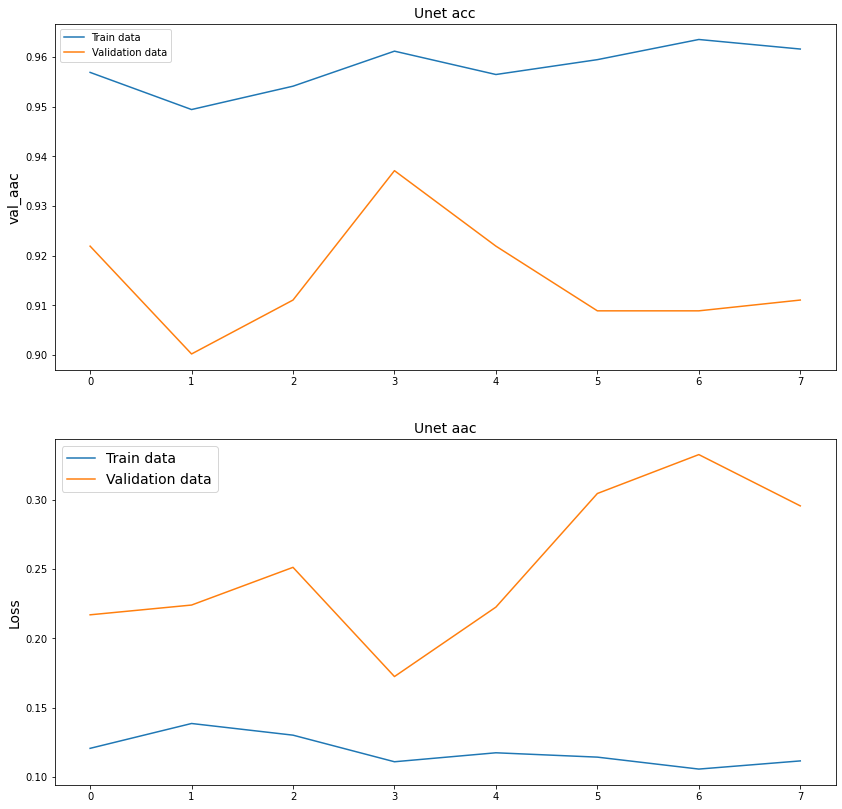

In [ ]:
history_visualize(history_unet, 'Unet')

In [ ]:
model_unet.save_weights("/content/drive/MyDrive/Data/unetw.hdf5")
model_unet.save('/content/drive/MyDrive/Data/unet')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/unet/assets


In [ ]:
score = model_unet.evaluate(test_gen, steps=len(test_gen))
print("Loss: {:.5}".format(score[0]))

Loss: 0.17892


In [ ]:
class_dict = {0: 'COVID19',
              1: 'NORMAL',
              2: 'PNEUMONIA'}

prediction:  NORMAL


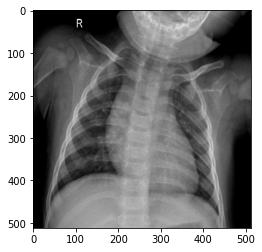

In [ ]:
test_im = cv2.imread("/content/drive/MyDrive/Data/test/NORMAL/NORMAL(1269).jpg")
test_im = cv2.resize(test_im, (512, 512), interpolation=cv2.INTER_NEAREST)
plt.imshow(test_im)
test_im = np.expand_dims(test_im, axis=0)
probs = model_unet.predict(test_im / 255)
pred_class = np.argmax(probs > 0.5)

pred_class = class_dict[pred_class]

print('prediction: ', pred_class)


##Xception


In [ ]:
baseModel = tf.keras.applications.Xception(input_shape=(512, 512, 3), weights='imagenet', include_top=False)


In [ ]:
for layer in baseModel.layers:
    layer.trainable = False

layer_Xce = baseModel.output
layer_Xce = keras.layers.AveragePooling2D()(layer_Xce)
layer_Xce = keras.layers.Flatten()(layer_Xce)
layer_Xce = keras.layers.Dense(256, activation="relu")(layer_Xce)
layer_Xce = keras.layers.BatchNormalization()(layer_Xce)
layer_Xce = keras.layers.Dense(3, activation='softmax')(layer_Xce)

model_Xce = keras.models.Model(inputs=baseModel.input, outputs=layer_Xce)

In [ ]:
checkpoint_path = r"/content/drive/MyDrive/Data/Xce_16.hdf5"

callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True,
                                    save_weights_only=False, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=1, mode='auto')
]

optim = keras.optimizers.Adam(lr=0.0001)

model_Xce.compile(optimizer=optim, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
history_Xce = model_Xce.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=15,
    callbacks=callbacks,
    validation_data=train_gen_val,
    validation_steps=len(train_gen_val),
    class_weight=None)

Epoch 1/15
669/669 [==============================] - 432s 641ms/step - loss: 0.6557 - accuracy: 0.8042 - val_loss: 0.3404 - val_accuracy: 0.9089

Epoch 00001: val_accuracy improved from -inf to 0.90889, saving model to /content/drive/MyDrive/Data/Xce_16.hdf5
Epoch 2/15
669/669 [==============================] - 438s 654ms/step - loss: 0.3122 - accuracy: 0.9042 - val_loss: 0.2297 - val_accuracy: 0.9176

Epoch 00002: val_accuracy improved from 0.90889 to 0.91757, saving model to /content/drive/MyDrive/Data/Xce_16.hdf5
Epoch 3/15
669/669 [==============================] - 432s 644ms/step - loss: 0.2037 - accuracy: 0.9305 - val_loss: 0.1943 - val_accuracy: 0.9349

Epoch 00003: val_accuracy improved from 0.91757 to 0.93492, saving model to /content/drive/MyDrive/Data/Xce_16.hdf5
Epoch 4/15
669/669 [==============================] - 431s 643ms/step - loss: 0.1955 - accuracy: 0.9310 - val_loss: 0.1925 - val_accuracy: 0.9349

Epoch 00004: val_accuracy did not improve from 0.93492
Epoch 5/15
6

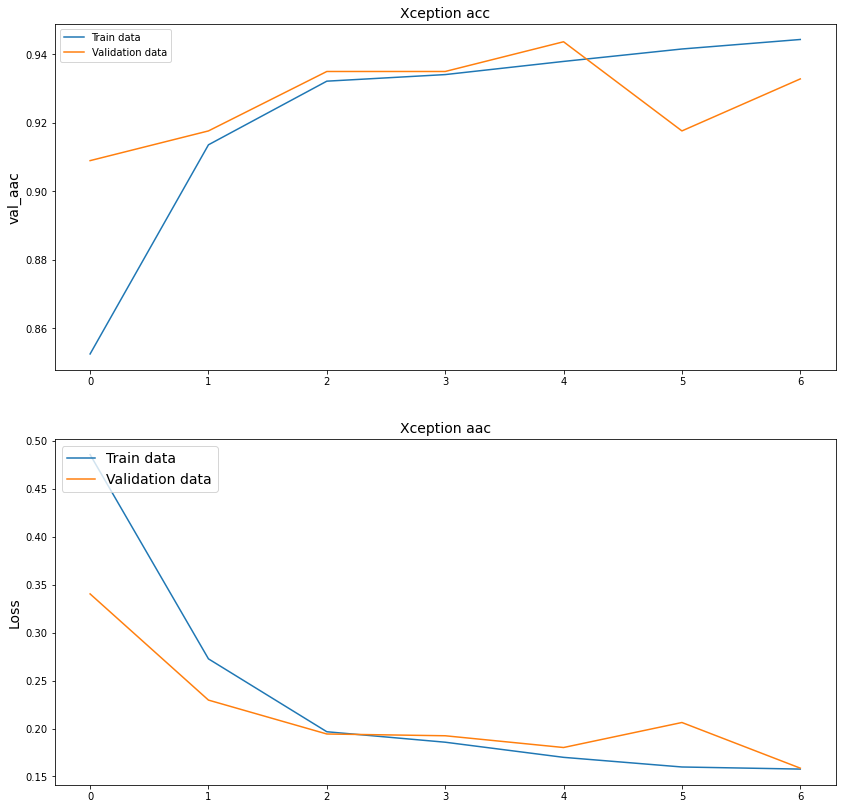

In [ ]:
history_visualize(history_Xce, 'Xception')

In [ ]:
hist_df = pd.DataFrame(history_Xce.history)

# save to json:  
hist_json_file = '/content/drive/MyDrive/Data/history_Xce.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)


In [ ]:
score = model_Xce.evaluate(test_gen, steps=len(test_gen))
print("Loss: {:.5}".format(score[0]))

Loss: 0.17865


In [ ]:
model_Xce.save_weights("/content/drive/MyDrive/Data/Xce.hdf5")
model_Xce.save('/content/drive/MyDrive/Data/Xce')